# Merge con SCIA

Merge delle stesse stazioni: si usano parametri restrittivi. Il focus è eliminare dati ripetuti. NON è gap filling.

In [10]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(dplyr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source("src/database/startup.R")
source("src/database/query/data.R")
source("src/database/query/metadata.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/database/plot.R")
source("notebooks/integrazioni_nazionali/ISAC/procedures/taggers.R")

conns <- load_dbs()


In [2]:
query <- glue::glue_sql(
    "
        WITH state_station AS (
            SELECT DISTINCT on (s.id)
                s.dataset,
                s.id,
                s.geom,
                s.geog
            FROM station_geo s
        )
        SELECT
            sx.dataset AS dataset_x,
            sx.id AS id_x,
            sy.dataset AS dataset_y,
            sy.id AS id_y,
            ST_Distance(sx.geog, sy.geog) AS distance
        FROM state_station sx
        JOIN state_station sy
        ON ST_DWithin(sx.geog, sy.geog, 7000)
        WHERE sx.id != sy.id
    ",
    .con = conns$stations
)
close_stations <- dbGetQuery(conns$stations, query)
dbWriteTable(
    conns$data,
    "close_stations_tmp",
    close_stations,
    overwrite = TRUE
)


In [3]:
dbExecute(conns$data, "SET memory_limit = '14GB'")


[1] 0

In [4]:
metadata <- tbl(conns$data, "stations_tmp")
dbExecute(conns$data, "DROP TABLE IF EXISTS data_tmp")
data <- valid_data(conns$data) |>
    mutate(variable = as.integer(variable)) |>
    semi_join(metadata, join_by(station_id == id)) |>
    compute(temporary = FALSE, name = "data_tmp")
matches <- data |>
    valid_series() |>
    collect() |>
    series_matches(tbl(conns$data, "close_stations_tmp") |> collect(), asymmetric = TRUE, cmp = \(x, y) x > y) |>
    select(id_x, id_y, variable, distance)


[1] 0

In [12]:
analysis <- series_matches_analysis(matches, data, metadata)
# analysis <- read_parquet("notebooks/integrazioni_nazionali/analysis.parquet") |>
#     mutate(variable = as.integer(variable)) |>
#     mutate(balance = if_else(is.na(balance), 0, balance))


In [14]:
analysis |> write_parquet("notebooks/integrazioni_nazionali/analysis.parquet")

In [13]:
analysis |> write_xlsx_analysis("notebooks/integrazioni_nazionali/analysis.xlsx")


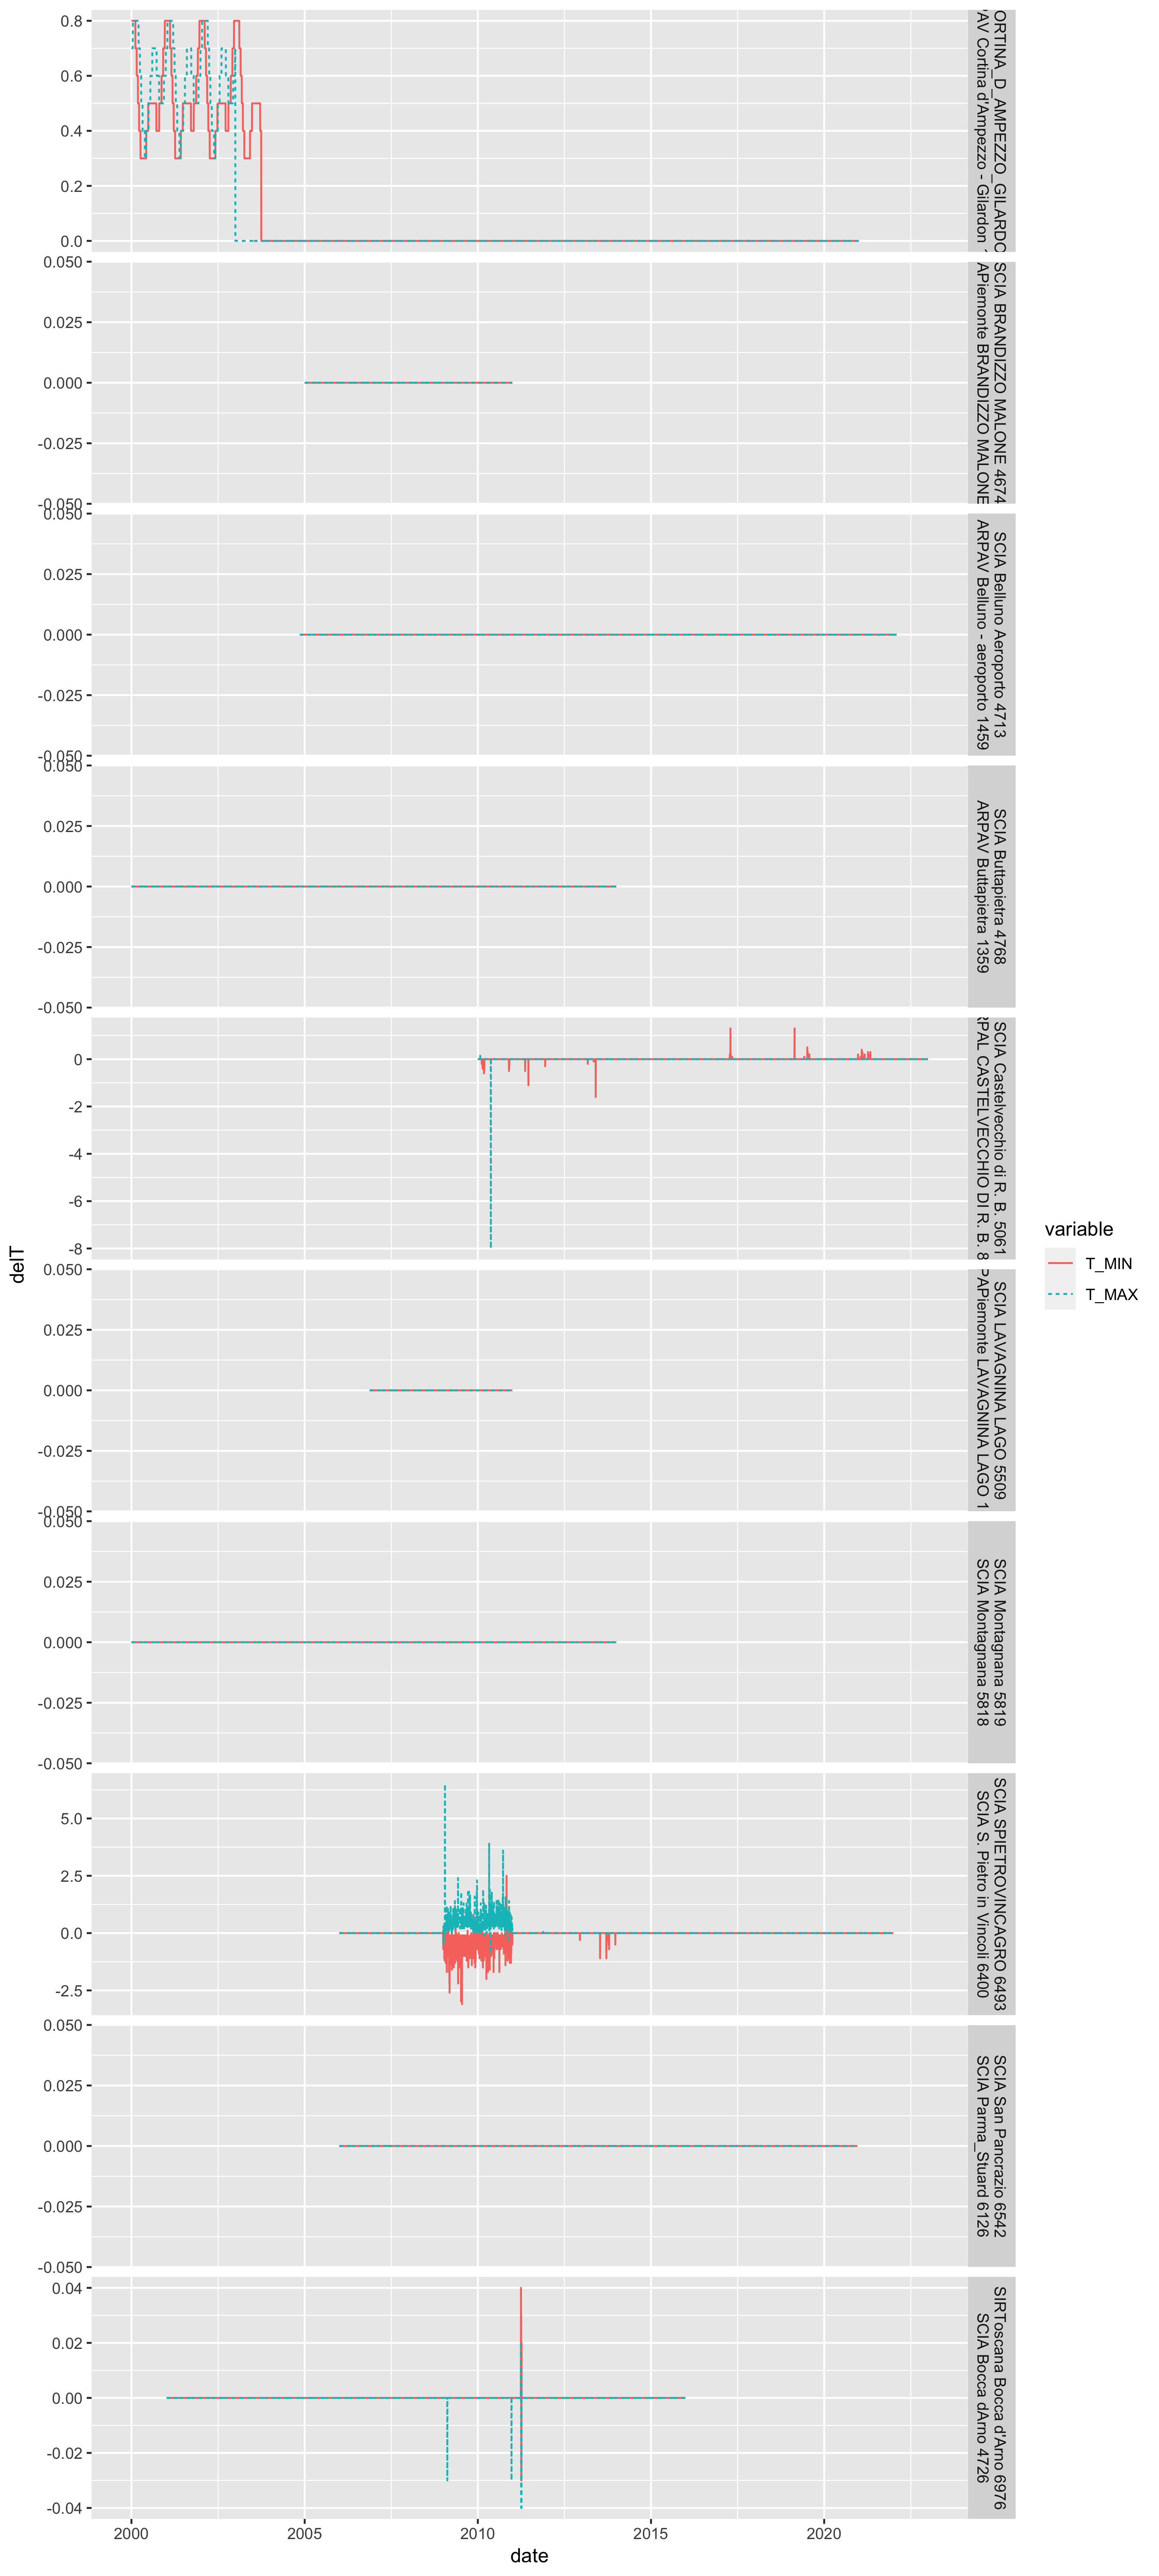

In [22]:
options(repr.plot.height = 20, repr.plot.res = 300)
source("src/database/plot.R")
source("notebooks/integrazioni_nazionali/ISAC/procedures/taggers.R")
atgg <- analysis |>
    # filter(dataset_x != "ISAC") |>
    tag_merge_same()
mfilter <- expr(tag_coincident)
atgg |>
    # filter(!!mfilter) |>
    # nrow()
    plot_random_matches(conns$data, !!mfilter, n = 10L)
# slice_max(distance)
# plot_alldiffs(atgg, conns$data, !!mfilter)


In [118]:
analysis |>
    tag_merge_same() |>
    filter(tag_statavg) |>
    nrow()


[1] 2111

In [27]:
source("notebooks/integrazioni_nazionali/ISAC/procedures/taggers.R")
source("src/merging/combining.R")
count_repeated <- function(cliques_list) {
    ids <- sapply(cliques_list, as_ids, USE.NAMES = FALSE) |> unlist()
    length(ids) - length(unique(ids))
}
tagged_analysis <- analysis |>
    # filter(dataset_x != "ISAC" & dataset_y != "ISAC") |>
    tag_merge_same()
graph_edgelist <- tagged_analysis |>
    arrange(id_x, id_y, variable) |>
    select(id_x, id_y, variable, tag_merge_same)

graph_tmin <- graph_from_isedge(
    graph_edgelist |> filter(variable == -1L),
    tag_merge_same,
    FALSE
)
# |> add_nonmatching(metadata |> collect())

mc <- max_cliques(graph_tmin)
from_n <- tagged_analysis |>
    filter(tag_merge_same) |>
    nrow()
to_n <- length(mc)
with_rep <- count_repeated(mc)

paste0("From: ", from_n, " to: ", to_n, " with rep: ", with_rep)


[1] "From: 3514 to: 1111 with rep: 20"

In [28]:
cliques_to_groups <- function(clique_list) {
    tibble(id = unlist(lapply(clique_list, names)), cid = rep(seq_along(mc), sapply(mc, length)))
}


In [30]:
atgg |>
    filter(id_x %in% c(6428L, 1142L, 9731L) & id_y %in% c(6428L, 1142L, 9731L)) |>
    select(variable, starts_with("id"), starts_with("dataset"), starts_with("name"), f0, maeT, delT, monthlymaeT, monthlydelT, climaticdelT, balance, distance, valid_days_inters, tag_coincident, tag_statavg, tag_nooverlap)


variable,id_x,id_y,dataset_x,dataset_y,name_x,name_y,f0,maeT,delT,monthlymaeT,monthlydelT,climaticdelT,balance,distance,valid_days_inters,tag_coincident,tag_statavg,tag_nooverlap
<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
1,9731,6428,ISAC,SCIA,SAN_DAMIANO_MACRA,SAN DAMIANO MACRA,0.3875969,0.38150106,-0.38150106,0.52180351,-0.35751055,-0.41495888,-1,136.740030,2838,FALSE,FALSE,FALSE
-1,6428,1142,SCIA,ARPAPiemonte,SAN DAMIANO MACRA,SAN DAMIANO MACRA,1.0000000,0.00000000,0.00000000,0.04396896,0.03927701,0.46255517,0,7.490303,2893,TRUE,FALSE,FALSE
1,9731,1142,ISAC,ARPAPiemonte,SAN_DAMIANO_MACRA,SAN DAMIANO MACRA,0.7436765,0.15995588,-0.15995588,0.27628167,-0.17816112,-0.26233950,-1,137.558889,6800,TRUE,FALSE,FALSE
1,6428,1142,SCIA,ARPAPiemonte,SAN DAMIANO MACRA,SAN DAMIANO MACRA,1.0000000,0.00000000,0.00000000,0.04179488,0.02022545,0.15261938,0,7.490303,2894,TRUE,FALSE,FALSE
-1,9731,1142,ISAC,ARPAPiemonte,SAN_DAMIANO_MACRA,SAN DAMIANO MACRA,0.7365200,0.08665112,-0.08665112,0.12461058,-0.04476256,0.03660194,-1,137.558889,6862,TRUE,FALSE,FALSE
-1,9731,6428,ISAC,SCIA,SAN_DAMIANO_MACRA,SAN DAMIANO MACRA,0.3682739,0.20775681,-0.20775681,0.25778455,-0.20907684,-0.42595322,-1,136.740030,2862,FALSE,FALSE,FALSE


In [29]:
cg <- cliques_to_groups(mc)
cg |> semi_join(cg |> group_by(id) |> filter(n() > 1L) |> ungroup(), by = "cid")


id,cid
<chr>,<int>
6273,65
6318,65
6428,88
1142,88
1142,89
9731,89
6477,138
6612,138
7085,259


In [11]:
source("src/merging/combining.R")
tgg <- group_series_matches(tagged_analysis, metadata, tag_merge_same, vertices_groups, FALSE)


In [12]:
dataset_prio <- c("SCIA", metadata |> distinct(dataset) |> collect() |> anti_join(tibble(dataset = c("SCIA", "ISAC"))) |> pull(dataset), "ISAC")


Joining with `by = join_by(dataset)`


In [54]:
source("src/merging/combining.R")
rsg <- tgg[[1]] |> rank_inside_group(metadata, dataset_prio, dataset, valid_days)
rmt <- rsg |> ranked_match_table(analysis)


In [55]:
dt <- merge_series_group(tgg[[1]], metadata, data, analysis, dataset_prio, dataset, valid_days)


In [62]:
tgg[[1]] |> filter(gid == 1L, variable == -1L)


id,gid,variable
<int>,<int>,<int>
163,1,-1
161,1,-1
5421,1,-1
5422,1,-1


In [64]:
library(tsibble)
dt |>
    filter(gid == 1L, variable == -1L) |>
    collect() |>
    as_tsibble(key = c("gid", "variable"), index = "date") |>
    distinct(station_id)


station_id
<int>
5422
161
5421


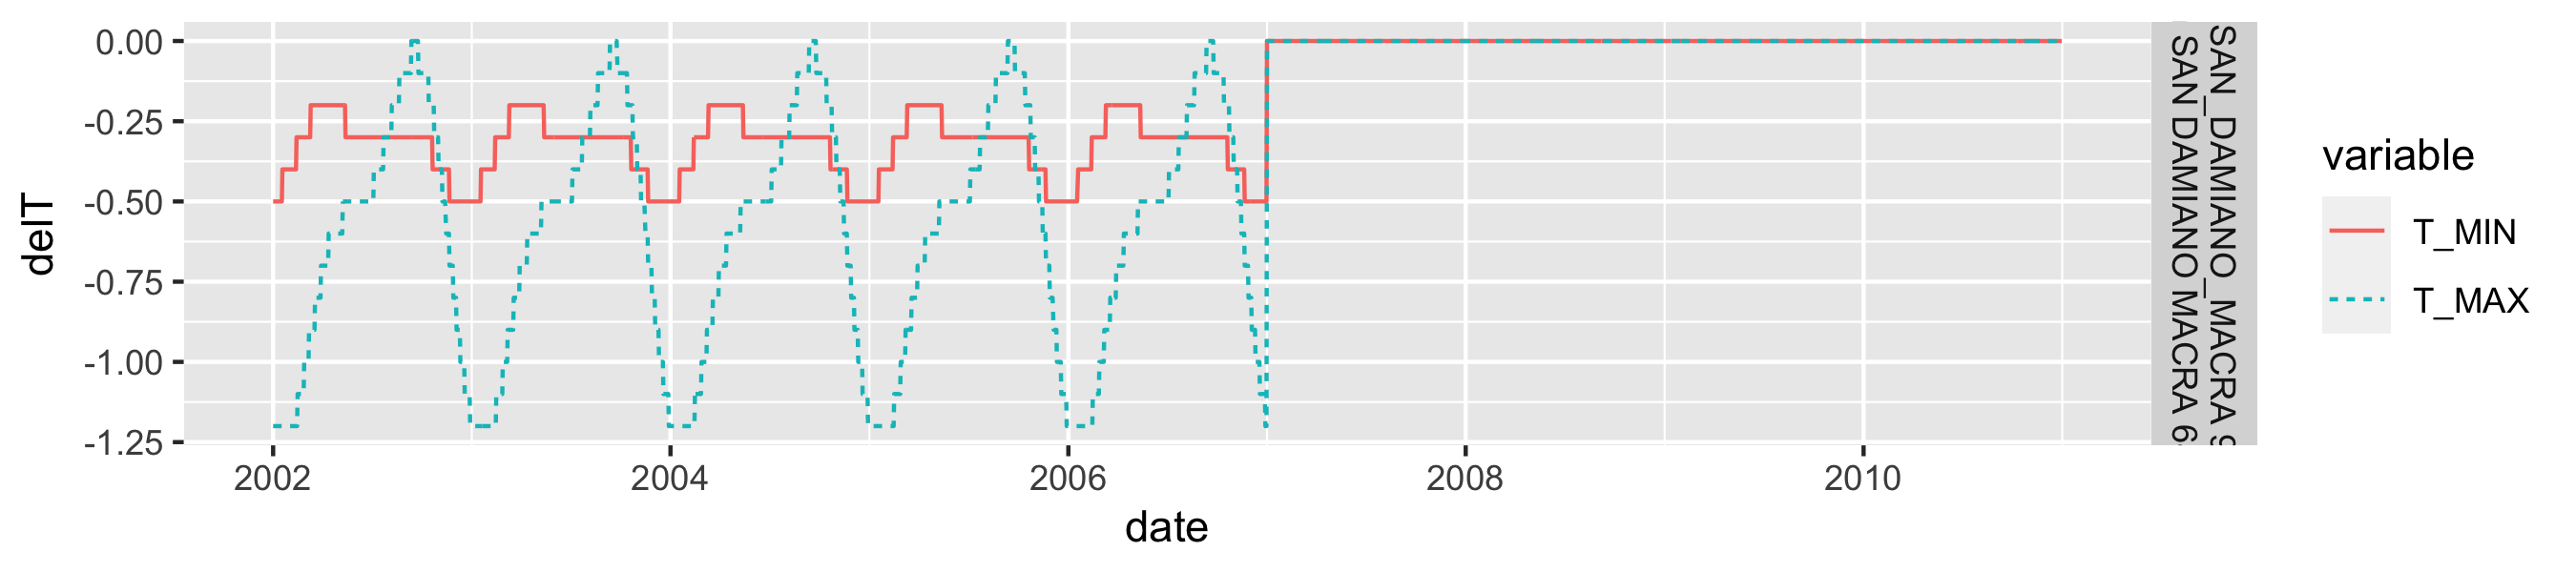

In [34]:
options(repr.plot.height = 2, repr.plot.res = 300)
plot_diffs(atgg |> filter(id_x == 9731L, id_y == 6428L) |> mutate(dataset_x = "boh", dataset_y = "boh"), conns$data)


In [69]:
metadata |>
    semi_join(tibble(id = c(5421L, 5422L, 161L, 163L), variable = -1L), copy = T) |>
    collect()


Joining with `by = join_by(id)`


id,previous_id,dataset,name,network,lon,lat,elevation,state,first_registration,last_registration,valid_days,original_id,original_dataset,passed_qc1,glo30m_elevation,glo30asec_elevation
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<date>,<date>,<int>,<chr>,<chr>,<lgl>,<dbl>,<dbl>
161,108,ARPAE,Granarolo Faentino,locali,11.92193,44.36161,15,Emilia-Romagna,2005-12-31,2022-08-08,6046,locali/Granarolo Faentino/15,ARPAE,NA,15.7930,16.49600
163,110,ARPAE,Granarolo Faentino 0,locali,11.95860,44.36013,15,Emilia-Romagna,2005-12-31,2011-12-20,2181,locali/Granarolo Faentino 0/15,ARPAE,NA,14.3121,14.59936
5421,969,SCIA,Granarolo Faentino,RETE EMILIA ROMAGNA OPENDATA,11.92193,44.36161,NA,Emilia-Romagna,2006-01-01,2022-08-08,5841,14263,SCIA,NA,15.7930,16.49600
5422,970,SCIA,Granarolo Faentino,Regionale ARPA ER,11.95860,44.36013,65,Emilia-Romagna,2004-09-27,2021-12-31,6098,7103,SCIA,NA,14.3121,14.59936


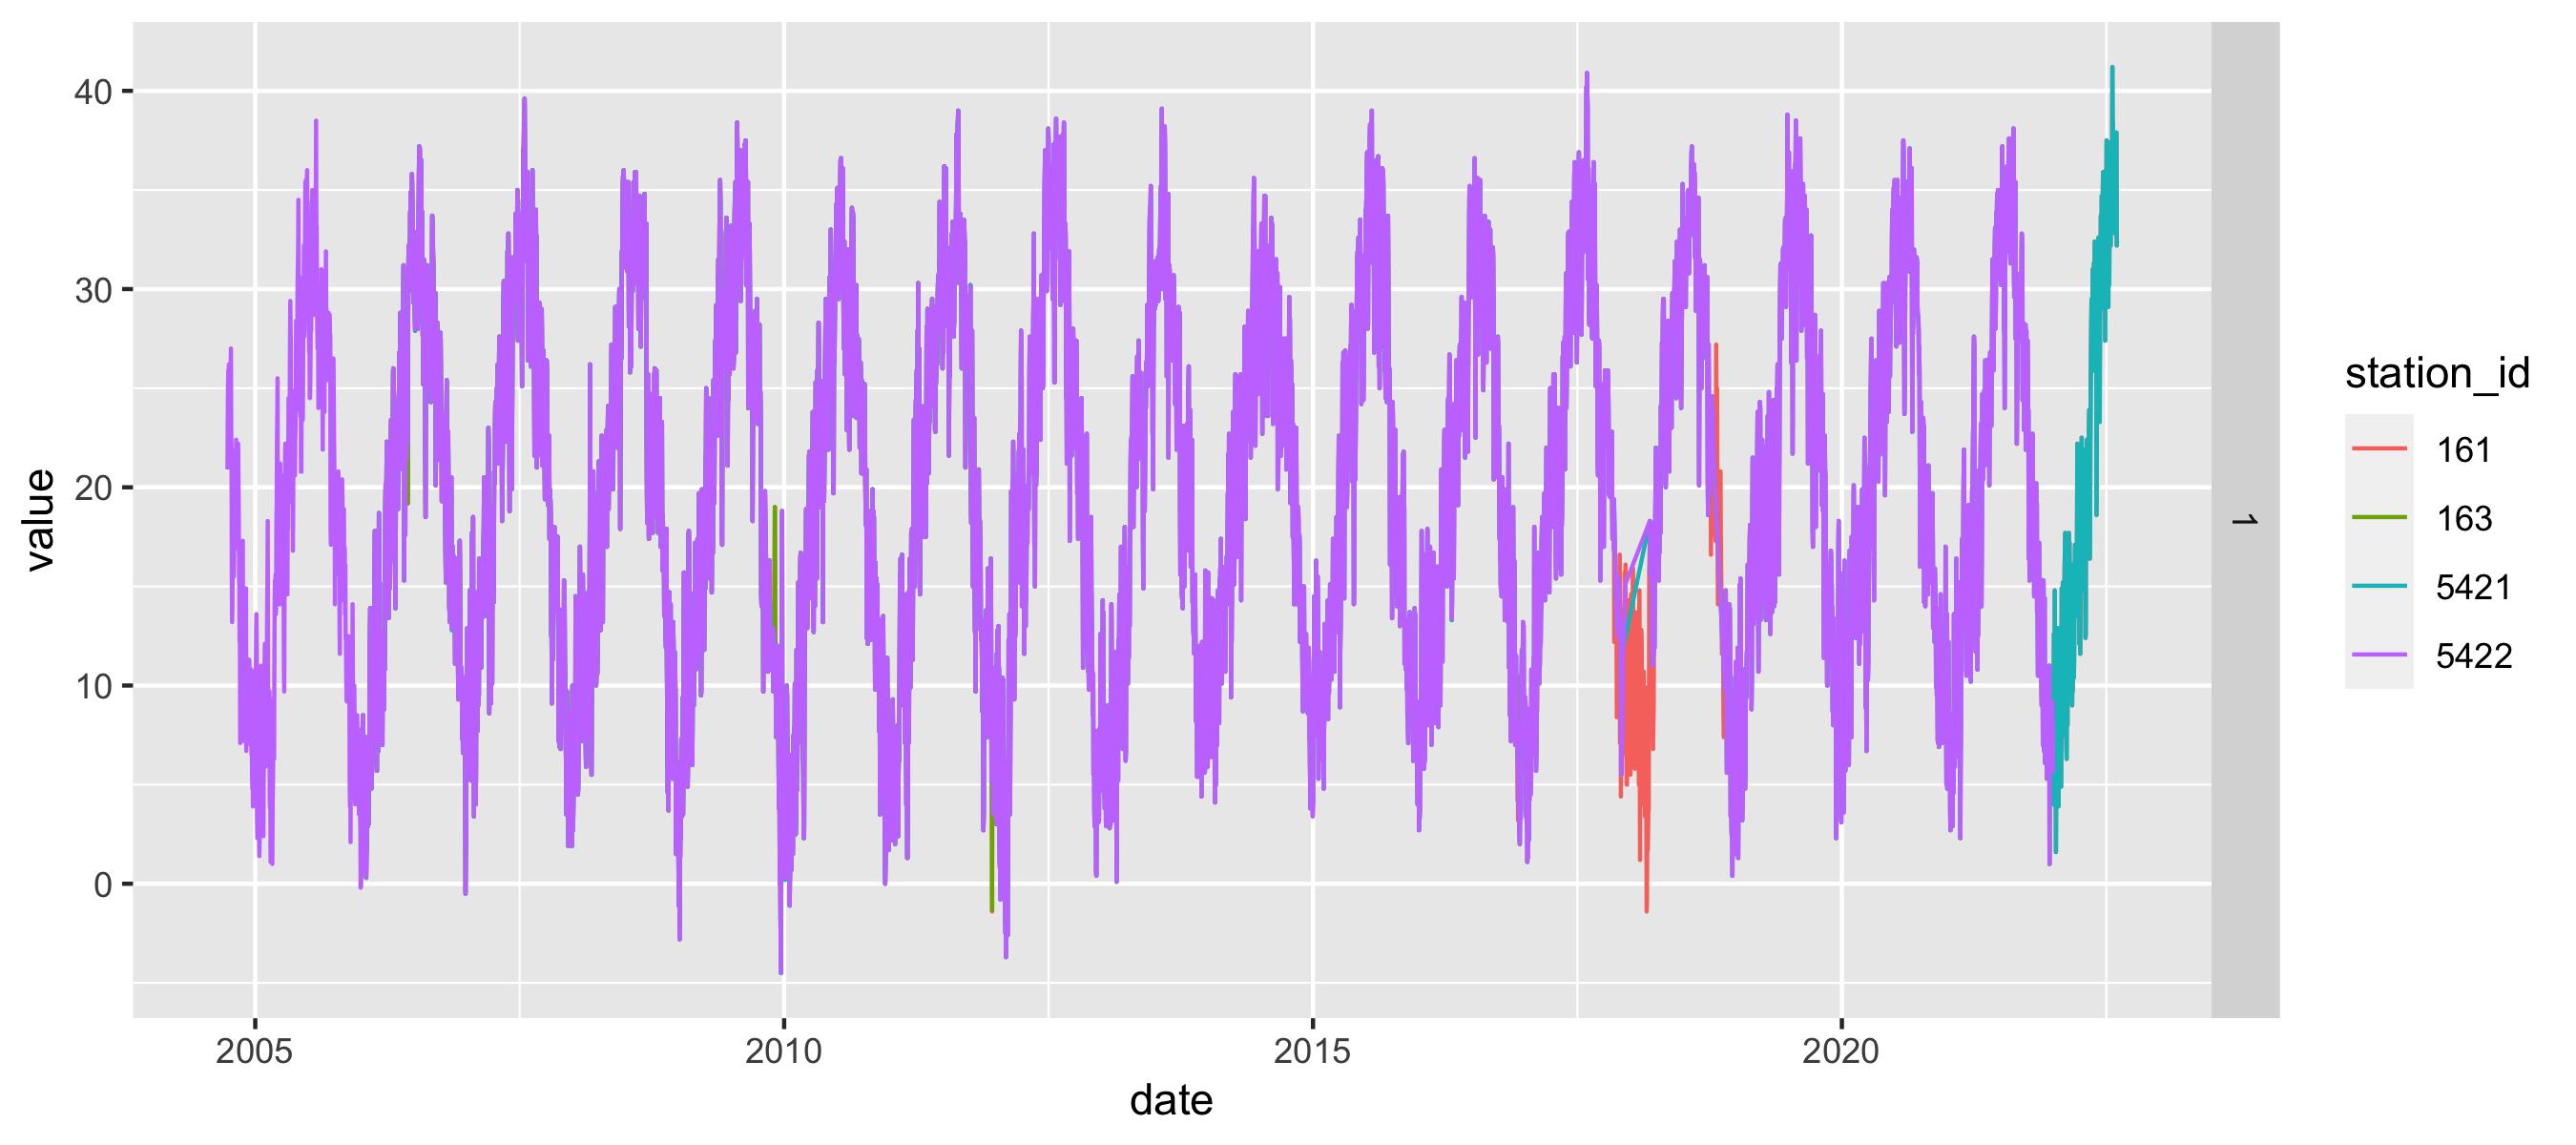

In [79]:
plot_stations(tibble(station_id = c(5421L, 5422L, 161L, 163L), variable = 1L), conns$data, same_period = F)


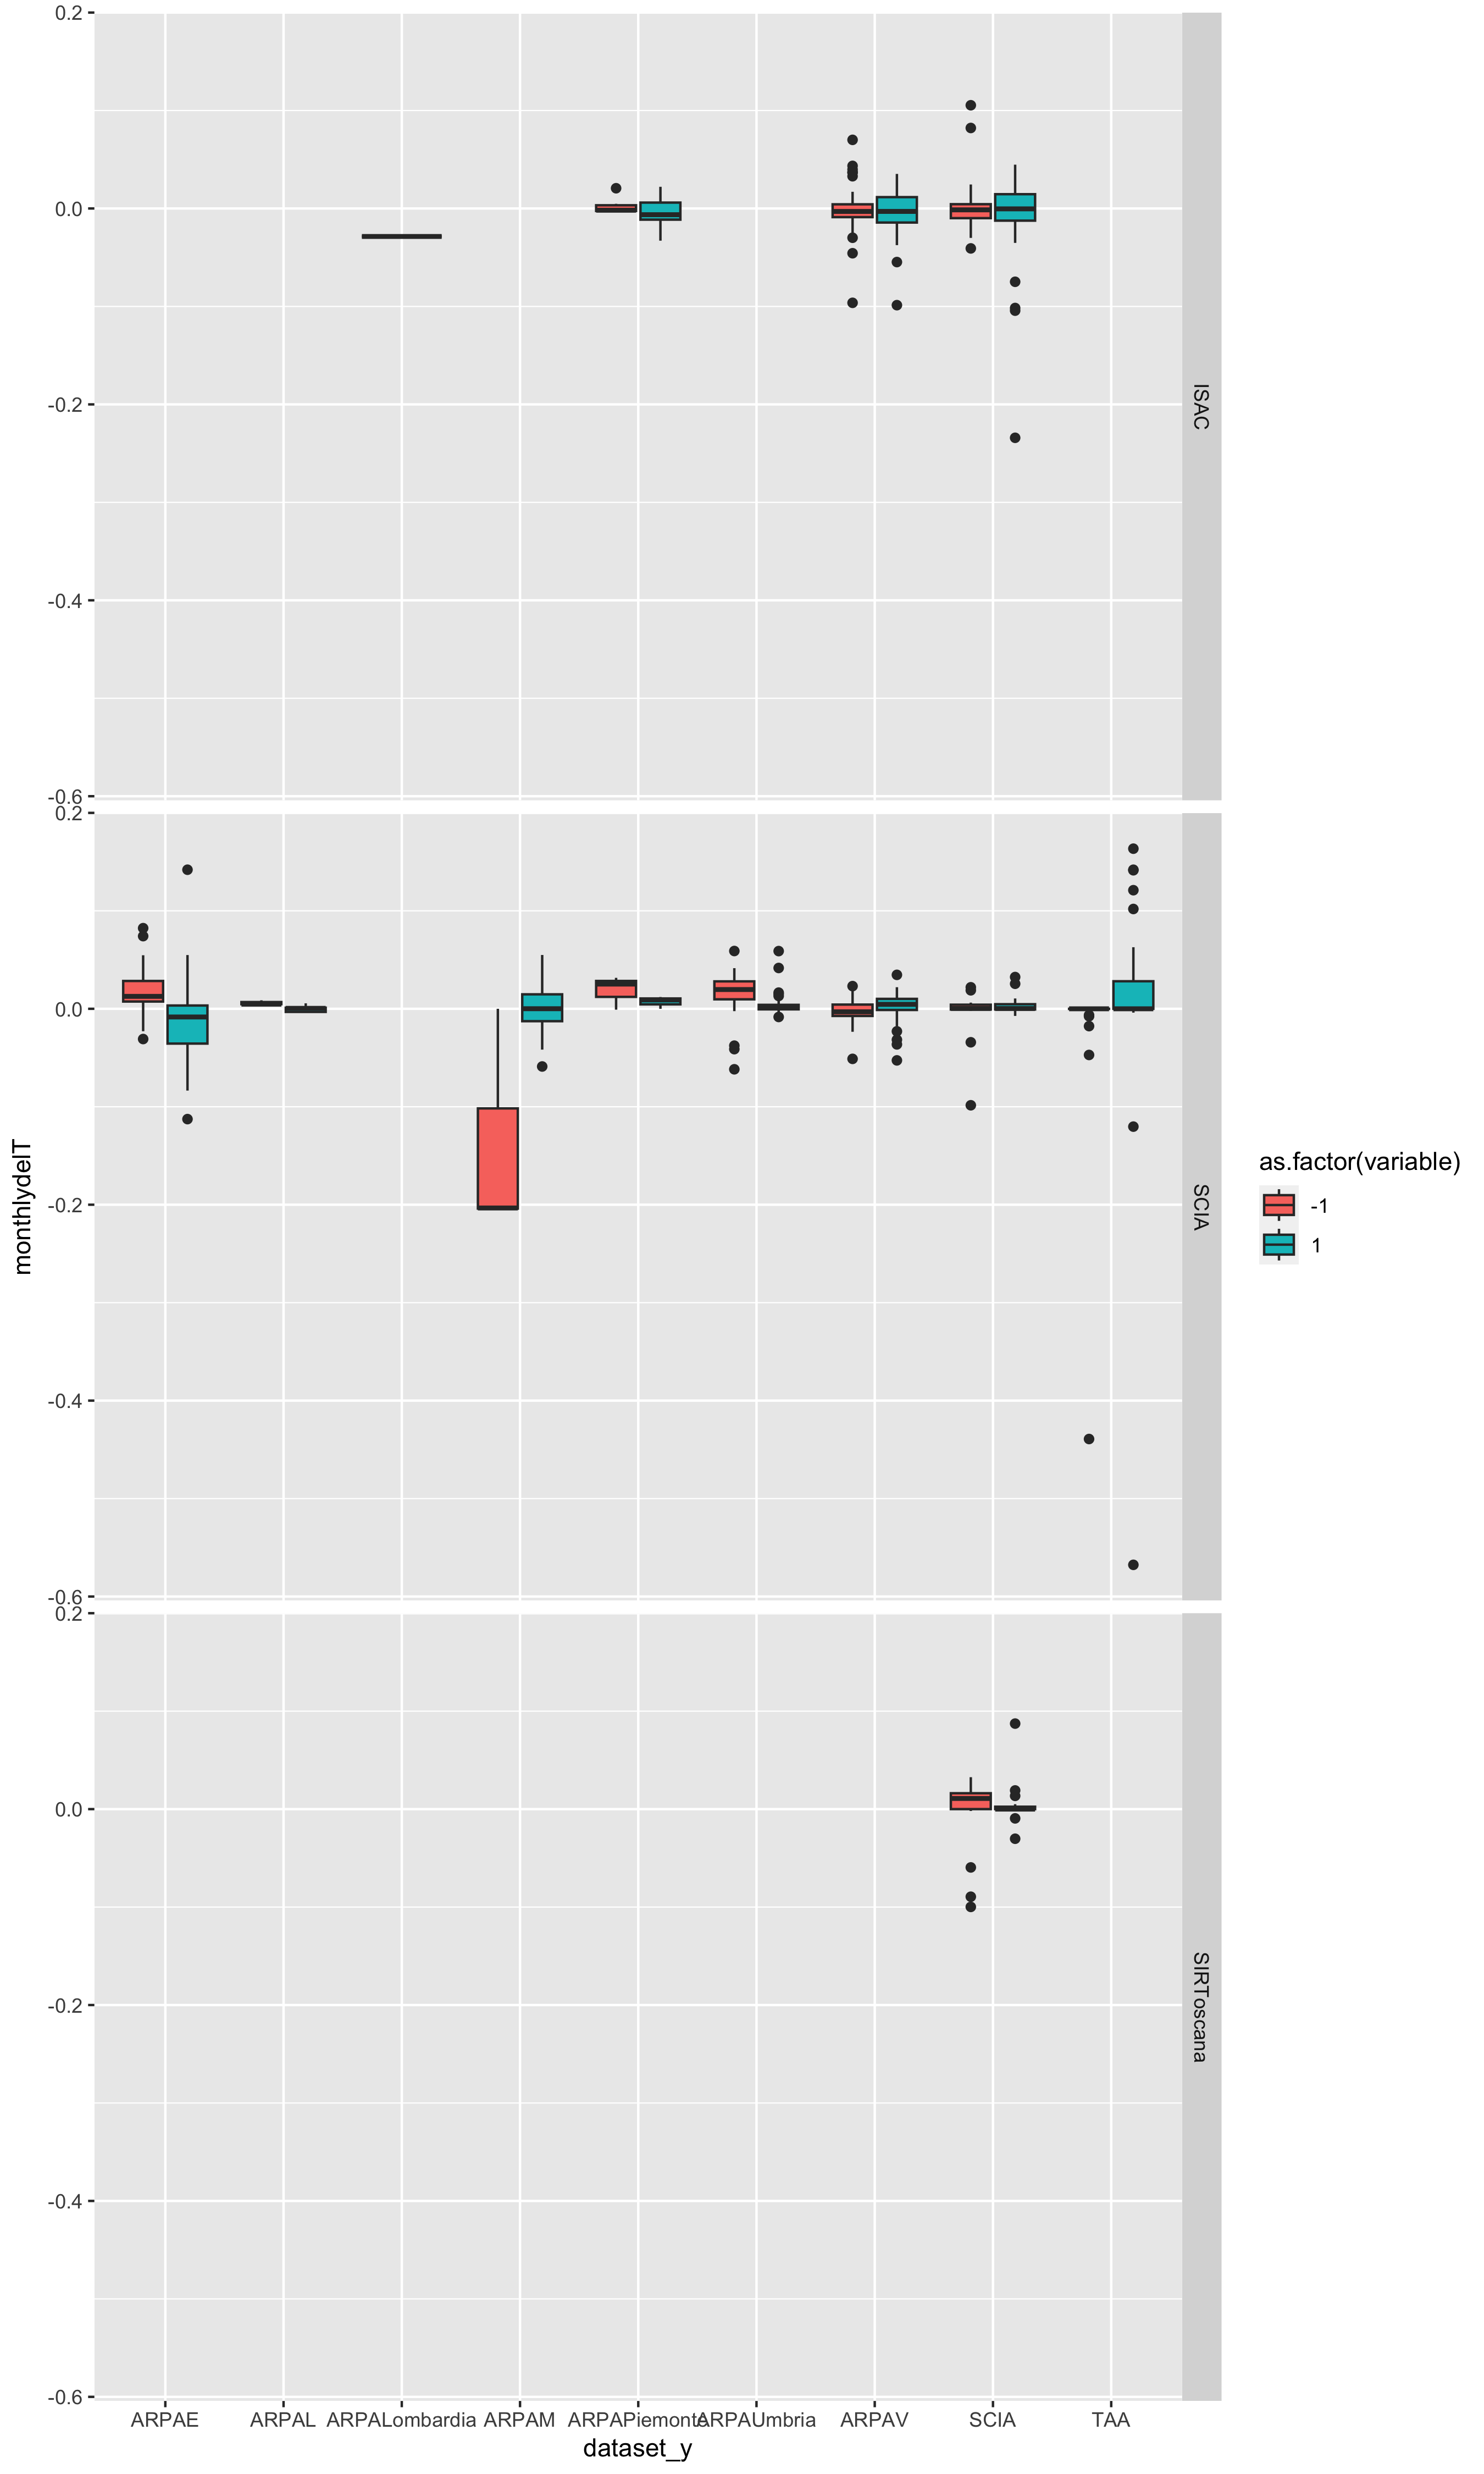

In [10]:
analysis |>
    filter(f0 > 0.9 & overlap_union > 0.9) |>
    ggplot() +
    geom_boxplot(aes(x = dataset_y, y = monthlydelT, fill = as.factor(variable))) +
    facet_grid(dataset_x ~ .)


In [11]:
tag_merge_same(analysis) |> filter(tag_merge_same)


id_x,id_y,variable,maeT,delT,sdT,valid_days_x,valid_days_y,valid_days_inters,valid_days_union,...,delH,delZm,delZsec,norm_name_x,norm_name_y,strSym,tag_coincident,tag_included,tag_introduced_lag,tag_merge_same
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>
6740,4430,-1,0.0137426901,0.0014619883,0.102880351,359,344,342,361,...,0.000000,0.0000000,0.000000,trento - via zambra - top cent,trento (ufficio),0.6194444,TRUE,FALSE,FALSE,TRUE
5952,4244,-1,0.0000000000,0.0000000000,0.000000000,8401,8401,8401,8401,...,-64.000000,0.0000000,0.000000,ora,auer ora,0.4722222,TRUE,TRUE,FALSE,TRUE
6150,6149,1,0.0000000000,0.0000000000,0.000000000,8358,5089,5089,8358,...,-101.000000,0.0000000,0.000000,passo xomo posina,passo xomo (posina),0.9789474,FALSE,TRUE,FALSE,TRUE
4714,1282,1,0.0000000000,0.0000000000,0.000000000,2309,2311,2309,2311,...,-4.000000,10.0468750,41.536102,belluno viale europa,belluno viale europa,1.0000000,TRUE,TRUE,FALSE,TRUE
6097,1059,1,0.0000000000,0.0000000000,0.000000000,2884,7656,2884,7656,...,-133.000000,0.0000000,0.000000,premia,premia,1.0000000,FALSE,TRUE,FALSE,TRUE
6178,5186,1,0.0000000000,0.0000000000,0.000000000,5074,8350,5074,8350,...,182.000000,0.0000000,0.000000,pian del crep (zoldo alto),crep di pecol,0.6559829,FALSE,TRUE,FALSE,TRUE
6182,1451,1,0.0000000000,0.0000000000,0.000000000,5049,8069,5049,8069,...,1.000000,1.1528320,0.000000,piana di marcesina - rendole,piana di marcesina - rendole,1.0000000,FALSE,TRUE,FALSE,TRUE
7172,6228,-1,0.0005134788,0.0005134788,0.014331487,3336,779,779,3336,...,64.000000,-0.4092560,0.000000,pontremoli depuratore,pontremoli depuratore,1.0000000,FALSE,TRUE,FALSE,TRUE
5024,887,-1,0.0022157996,0.0022157996,0.044028985,3560,3116,3114,3562,...,0.000000,0.0000000,0.000000,carro,carro,1.0000000,FALSE,TRUE,FALSE,TRUE


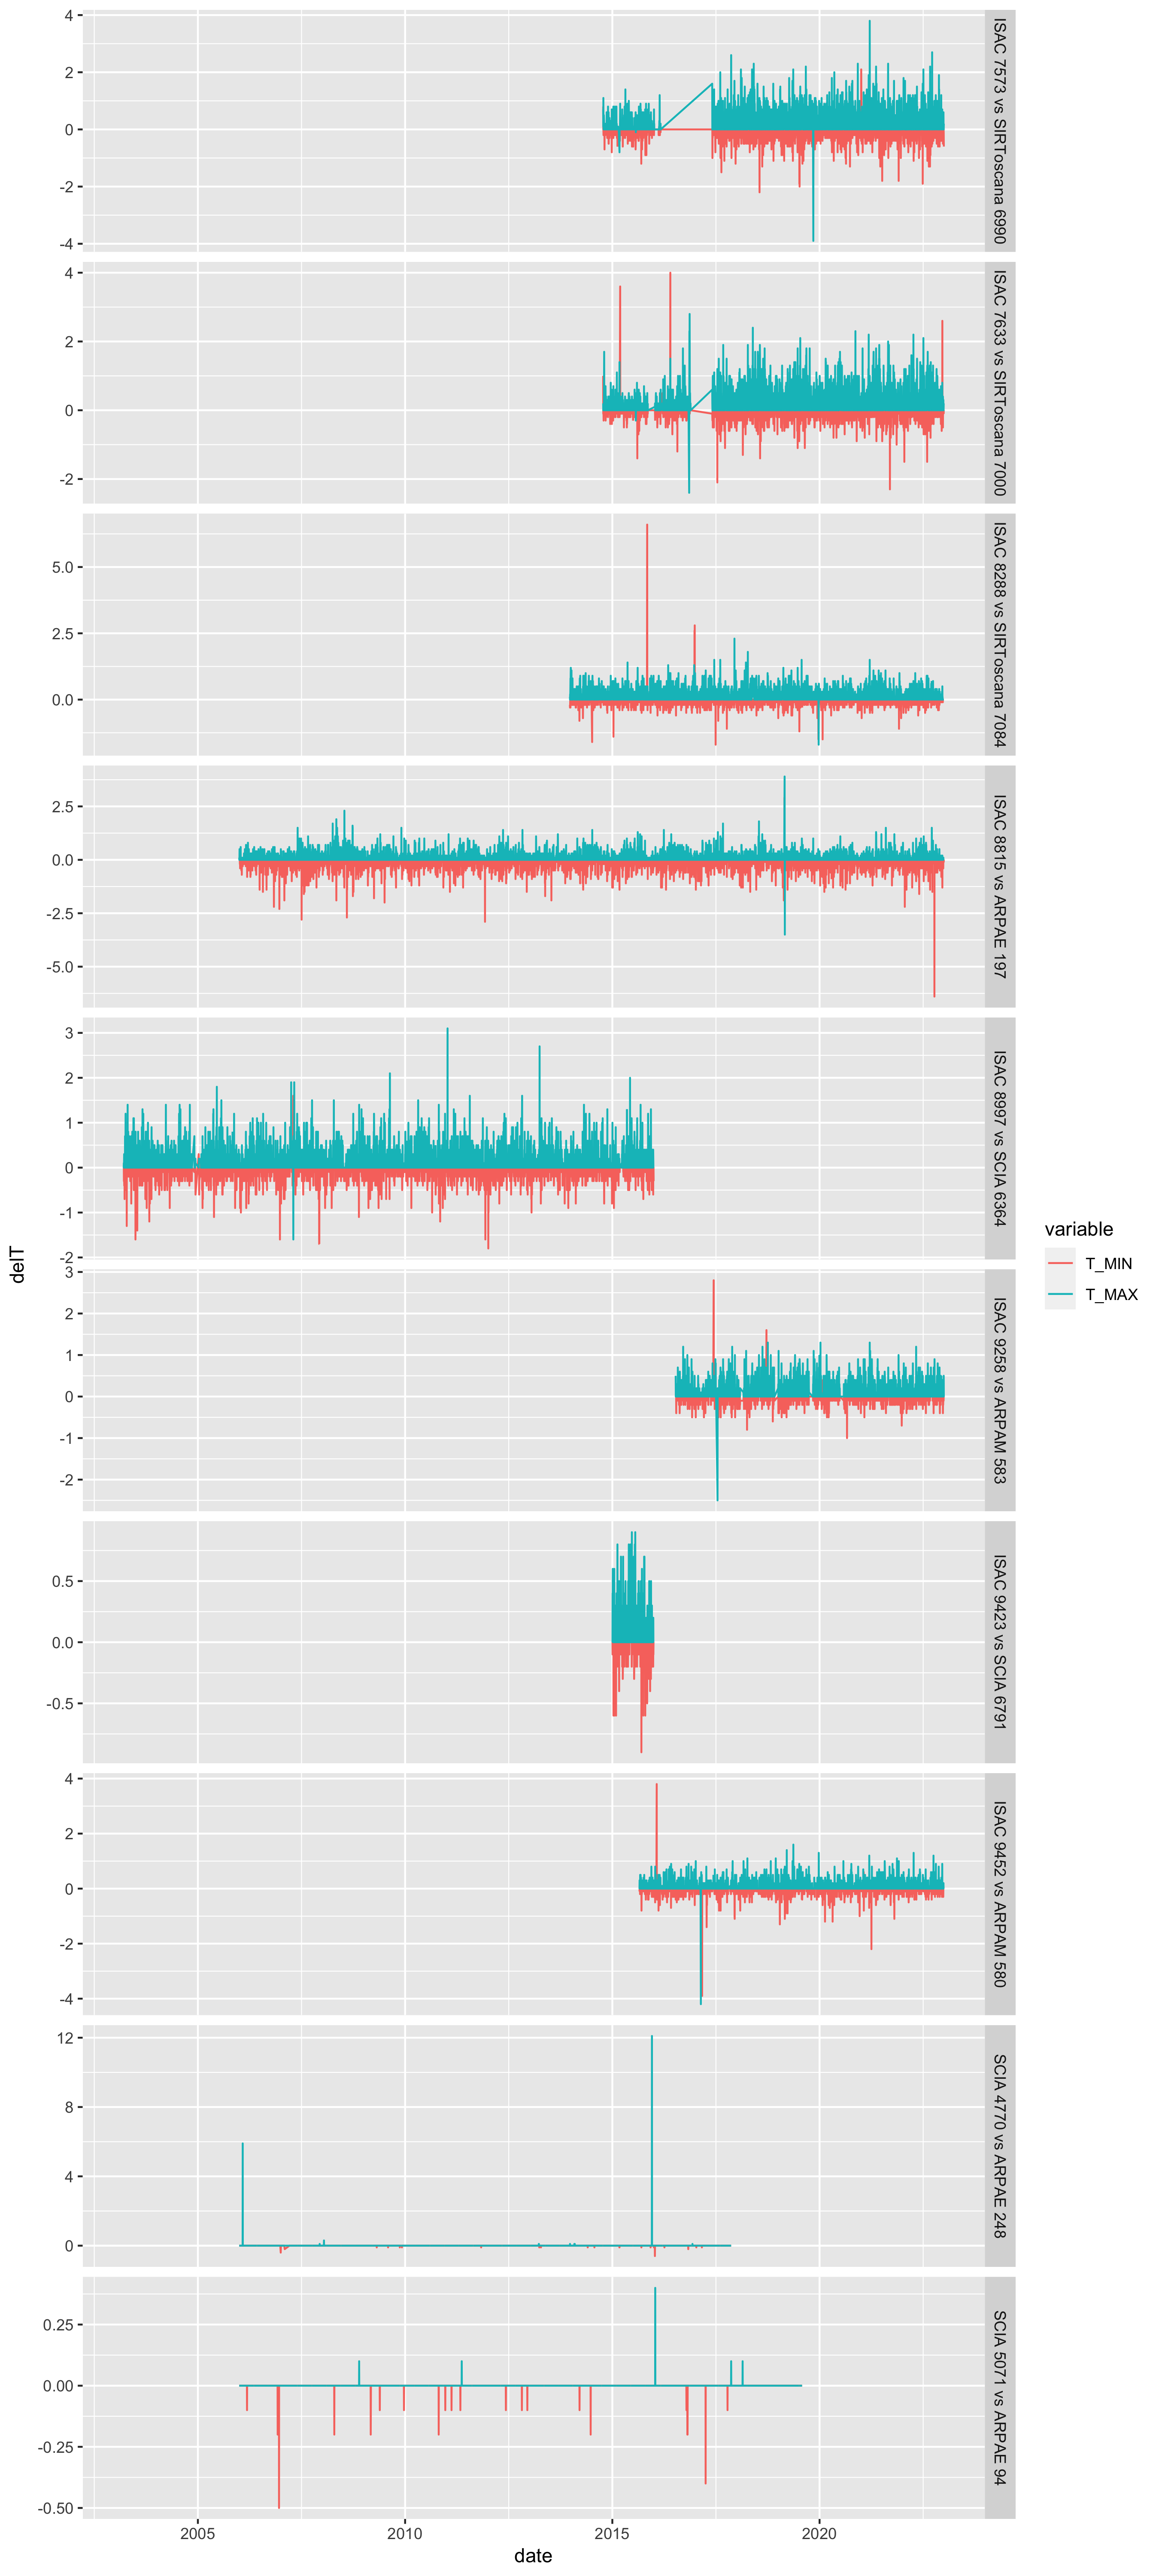

In [129]:
plot_random_matches(tagged_analysis, conns$data, tag_normal, n = 10L)


In [50]:
diffs <- pair_full_series(data, atgg |> filter(id_x == 9731L, id_y == 6428L)) |>
    mutate(diff = value_y - value_x, .keep = "unused") |>
    filter(abs(diff) > 1e-4) |>
    mutate(nextyear = date + years(1))
    
    


In [49]:
diffs |> inner_join(diffs, join_by(id_x, id_y, variable, nextyear == date)) |> mutate(lagged = diff.y - diff.x) |> summarise(lagged = sum(lagged, na.rm = T))

# Source:   SQL [1 x 1]
# Database: DuckDB v0.9.2 [root@Darwin 23.2.0:R 4.3.2/:memory:]
     lagged
      <dbl>
1 -1.97e-14

In [15]:
source("src/load/load.R")

In [18]:

read.series.single("BRUN", "T_MIN", "TN_VEN_BL_ANDRAZ_CERNADOI_01_200251582.raw", "raw")

ERROR: Error: '/Users/davidenicoli/Local_Workspace/Datasets/DPC/01_DATI_SINTESI_TN/TN_VEN_BL_ANDRAZ_CERNADOI_01_200251582.raw' does not exist.


In [23]:
library(stringr)
metadata |> collect() |> filter(stringr::str_detect(str_to_lower(name), "valbondione"))

id,previous_id,dataset,name,network,lon,lat,elevation,state,first_registration,last_registration,valid_days,original_id,original_dataset,passed_qc1,glo30m_elevation,glo30asec_elevation
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<date>,<date>,<int>,<chr>,<chr>,<lgl>,<dbl>,<dbl>
414,100,ARPALombardia,Valbondione,ARPALombardia,10.038607,46.06456,1784,Lombardia,2000-12-01,2022-12-31,6810,9008,ARPALombardia,NA,1794.6416,1689.4918
6828,2376,SCIA,Valbondione,Idrografica,9.984274,46.03076,954,Lombardia,2000-01-02,2004-12-30,934,8015,SCIA,NA,840.1762,965.7225
9353,2102,ISAC,VALBONDIONE,ISAC,10.038610,46.06456,1784,Lombardia,2004-12-08,2022-12-31,5305,LOM_BG_VALBONDIONE_01_000624900,ISAC,NA,1794.6416,1689.4918
